In [112]:
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdd_module import *
import pickle

####################################################################
# example beam model raw data


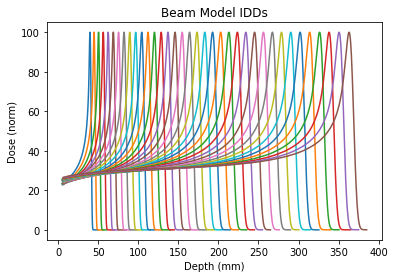

Beam model energies (MeV): 
[70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0]
####################################################################
# example IDD analysis
Metrics generated by PeakProprties class: 
{'NISTRange': 176.3, 'Prox80': 169.1066350148368, 'Prox90': 170.77898398674768, 'Dist90': 175.42377937336815, 'Dist80': 176.30140962288687, 'NISTDiff': 0.0014096228868538674, 'Dist20': 180.425559566787, 'Dist10': 181.56160493827159, 'PTPR': 3.815079334440027, 'FallOff': 4.124149943900136, 'PeakWidth': 7.194774608050068, 'HaloRat': 57.67525440323169}
####################################################################
# example raw data from directory


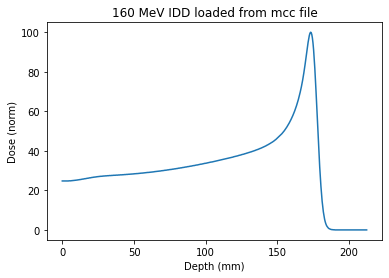

160 MeV IDD data: 
160.0


In [113]:
# examples

#########################################################################
# load IDD raw data
bm_asc = 'TPS_IDD_70-245-MeV_v2.0.asc'
bm_data = DepthDoseFile(bm_asc)

# example beam model raw data
print('####################################################################')
print('# example beam model raw data')
for energy in bm_data.data:
    depth = energy[0]
    dose = energy[1]
    plt.plot(depth, dose)

plt.title("Beam Model IDDs")
plt.xlabel("Depth (mm)")
plt.ylabel("Dose (norm)")
plt.show()

print("Beam model energies (MeV): ")
print(bm_data.energy)

# example IDD analysis
print('####################################################################')
print('# example IDD analysis')
bm160 = bm_data.data[18]  # select the 160 MeV IDD and analyse its properties
en = bm_data.energy[18]
bm_anal = PeakProperties(data=bm160, energy=en, plateau_depth=25, bortfeld_fit_bool=False)
print('Metrics generated by PeakProprties class: ')
print(bm_anal.__dict__)

# example raw data from directory
print('####################################################################')
print('# example raw data from directory')
mcc_dir = 'O:\protons\Work in Progress\AlexG\pdd-analysis\data\mcc'
data = directory_to_dictionary(mcc_dir)
data_fromdir = data[160.0] # select a 160 MeV IDD from the raw files in the directory
depth = data_fromdir.data[0]
dose = data_fromdir.data[1]
plt.plot(depth, dose)
plt.title("160 MeV IDD loaded from mcc file")
plt.xlabel("Depth (mm)")
plt.ylabel("Dose (norm)")
plt.show()
print('160 MeV IDD data: ')
print(data_fromdir.energy)

# example gamma analysis
test_data = data_fromdir.data
#ref_data = 

#gamma = pdd_gamma(test_data, ref_data, setgamma, crit)

In [3]:
import glob
import pathlib

################ Assess plotting tank set up uncertainty:

### Stingray GA0 vs. GA270 - load raw data

# load pickle data
pickle_dir = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar'

# stingray at GA0
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0_1 = pickle.load(f)

pickle_file = os.path.join(pickle_dir,'20211117_SR_145_190_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g0 = {**sr_g0_1, **sr_g0_2}

# stingray at GA270 for 70 MeV to 160 MeV
pickle_file = os.path.join(pickle_dir,'20211102_SR_070_160_G270','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g270_1 = pickle.load(f)

# stingray at GA270 for 165 MeV to 245 MeV
pickle_file = os.path.join(pickle_dir,'20211101_SR_165_245_G270','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g270_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g270 = {**sr_g270_1, **sr_g270_2}

D80 Differences between GA 270 & GA0 for stingray at each energy: 


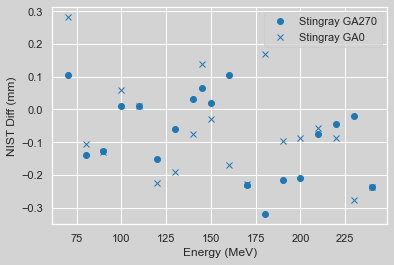

Stingray GA270-GA0 mean (StDev) D80 offset = -0.01 (0.160) mm
Stingray GA0 mean (StDev) NIST Difference = -0.07 (0.145) mm
Stingray GA270 mean (StDev) NIST Difference = -0.08 (0.122) mm


In [12]:
# Quantify GA270 & GA0 offset uncertainty by matching GA0 D80s to G270 D80s, and by assessing NIST depth differences
def sr_analyse(sr_g0, sr_g270, plot=False):
    diff_d80 = []
    sr270_nist = []
    sr0_nist = []
    srd80_0 = []
    srd80_270 = []
    sr_recorded_energies = []
    energies = np.arange(70.0,250.0,5.).tolist()

    for en in energies:
        try:
            sr270 = sr_g270[en].Dist80
            sr0 = sr_g0[en].Dist80
        except:
            continue
        
        srd80_0.append(sr0)
        srd80_270.append(sr270)
        diff_d80.append(sr270-sr0)
        sr270_nist.append(sr_g270[en].NISTDiff)
        sr0_nist.append(sr_g0[en].NISTDiff)
        sr_recorded_energies.append(en)

    sr_avg_offset = np.average(diff_d80)
    sr_med_offset = np.median(diff_d80)
    sr_sd_offset = np.std(diff_d80)
    sr_avg_nist270 = np.average(sr270_nist)
    sr_avg_nist0 = np.average(sr0_nist)
    sr_med_nist0 = np.median(sr0_nist)
    sr_std_nist270 = np.std(sr270_nist)
    sr_std_nist0 = np.std(sr0_nist)

    print("D80 Differences between GA 270 & GA0 for stingray at each energy: ")
    #print(diff_d80)
    plt.plot(sr_recorded_energies,sr270_nist,'o',c='tab:blue')
    plt.plot(sr_recorded_energies,sr0_nist,'x',c='tab:blue')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('NIST Diff (mm)')
    plt.legend(['Stingray GA270','Stingray GA0'])
    if plot:
        fig = plt.gcf()
        fig.savefig(plot,dpi=600)
        
    plt.show()
    print(f'Stingray GA270-GA0 mean (StDev) D80 offset = {sr_avg_offset:.2f} ({sr_sd_offset:.3f}) mm')
    print(f'Stingray GA0 mean (StDev) NIST Difference = {sr_avg_nist0:.2f} ({sr_std_nist0:.3f}) mm')
    print(f'Stingray GA270 mean (StDev) NIST Difference = {sr_avg_nist270:.2f} ({sr_std_nist270:.3f}) mm')
    return sr_avg_offset, sr_med_offset, sr_sd_offset, sr_avg_nist270, sr_avg_nist0, sr_med_nist0, sr_std_nist270, sr_std_nist0, sr0_nist, sr270_nist, sr_recorded_energies

sr_avg_offset, sr_med_offset, sr_sd_offset, sr_avg_nist270, sr_avg_nist0, sr_med_nist0, sr_std_nist270, sr_std_nist0, sr0_nist, sr270_nist, sr_recorded_energies = sr_analyse(sr_g0, sr_g270)



In [5]:
### Bragg Peak GA0 vs. GA270 
# load pickle data
pickle_dir = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar'

# bragg peak at GA0
pickle_file = os.path.join(pickle_dir,'20211125_BP_070_230_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    bp_g0 = pickle.load(f)

# bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'20211124_BP_070_240_G270','data_properties.p')
with open(pickle_file, 'rb') as f:
    bp_g270 = pickle.load(f)

D80 Differences between GA 270 & GA0 for bragg peak at each energy: 


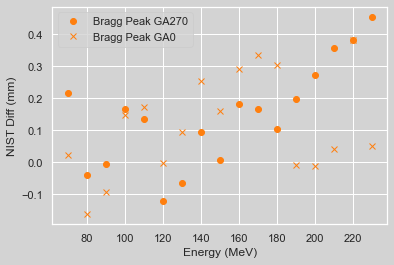

Bragg peak GA270-GA0 mean (StDev) D80 offset = 0.03 (0.188) mm
Bragg peak GA0 mean (StDev) NIST Difference = 0.12 (0.153) mm
Bragg peak GA270 mean (StDev) NIST Difference = 0.15 (0.157) mm


In [11]:
# Correct GA270 offset uncertainty by matching GA0 D80s to G270 D80s
def bp_analyse(bp_g0, bp_g270, plot=False):
    diff_d80 = []
    bp270_nist = []
    bp0_nist = []
    bpd80_0 = []
    bpd80_270 = []
    bp_recorded_energies = []
    energies = np.arange(70.0,250.0,5.).tolist()

    for en in energies:
        try:
            bp270 = bp_g270[en].Dist80
            bp0 = bp_g0[en].Dist80
        except:
            continue
        
        bpd80_0.append(bp0)
        bpd80_270.append(bp270)
        diff_d80.append(bp270-bp0)
        bp270_nist.append(bp_g270[en].NISTDiff)
        bp0_nist.append(bp_g0[en].NISTDiff)
        bp_recorded_energies.append(en)

    bp_avg_offset = np.average(diff_d80)
    bp_med_offset = np.median(diff_d80)
    bp_sd_offset = np.std(diff_d80)
    bp_avg_nist270 = np.average(bp270_nist)
    bp_avg_nist0 = np.average(bp0_nist)
    bp_med_nist0 = np.median(bp0_nist)
    bp_std_nist270 = np.std(bp270_nist)
    bp_std_nist0 = np.std(bp0_nist)

    print("D80 Differences between GA 270 & GA0 for bragg peak at each energy: ")
    #print(diff_d80)
    plt.plot(bp_recorded_energies,bp270_nist,'o',c='tab:orange')
    plt.plot(bp_recorded_energies,bp0_nist,'x',c='tab:orange')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('NIST Diff (mm)')
    plt.legend(['Bragg Peak GA270','Bragg Peak GA0'])
    if plot:
        fig=plt.gcf()
        fig.savefig(plot,dpi=600)
    
    plt.show()
        
    print(f'Bragg peak GA270-GA0 mean (StDev) D80 offset = {bp_avg_offset:.2f} ({bp_sd_offset:.3f}) mm')
    print(f'Bragg peak GA0 mean (StDev) NIST Difference = {bp_avg_nist0:.2f} ({bp_std_nist0:.3f}) mm')
    print(f'Bragg peak GA270 mean (StDev) NIST Difference = {bp_avg_nist270:.2f} ({bp_std_nist270:.3f}) mm')
    return bp_avg_offset, bp_med_offset, bp_sd_offset, bp_avg_nist270, bp_avg_nist0, bp_med_nist0, bp_std_nist270, bp_std_nist0, bp0_nist, bp270_nist, bp_recorded_energies

bp_avg_offset, bp_med_offset, bp_sd_offset, bp_avg_nist270, bp_avg_nist0, bp_med_nist0, bp_std_nist270, bp_std_nist0, bp0_nist, bp270_nist, bp_recorded_energies = bp_analyse(bp_g0, bp_g270)

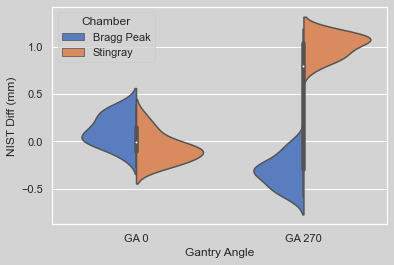

In [7]:
import seaborn as sns
import pandas as pd
def violin_diffs(sr0_nist, sr270_nist, bp0_nist, bp270_nist, plot=False):
    #split violin plot of uncorrected D80 Diffs vs. chamber vs. gantry angle
    nist_diffs_uncorrected = []
    nist_diffs_uncorrected.extend(bp0_nist)
    nist_diffs_uncorrected.extend(bp270_nist)
    nist_diffs_uncorrected.extend(sr0_nist)
    nist_diffs_uncorrected.extend(sr270_nist)
    chamber_uncorrected = []
    chamber_uncorrected.extend(['Bragg Peak']*len(bp0_nist))
    chamber_uncorrected.extend(['Bragg Peak']*len(bp270_nist))
    chamber_uncorrected.extend(['Stingray']*len(sr0_nist))
    chamber_uncorrected.extend(['Stingray']*len(sr270_nist))
    angle_uncorrected = []
    angle_uncorrected.extend(['GA 0']*len(bp0_nist))
    angle_uncorrected.extend(['GA 270']*len(bp270_nist))
    angle_uncorrected.extend(['GA 0']*len(sr0_nist))
    angle_uncorrected.extend(['GA 270']*len(sr270_nist))
    df_d80 = pd.DataFrame({'NIST Diff (mm)':nist_diffs_uncorrected, 'Chamber': chamber_uncorrected, 'Gantry Angle': angle_uncorrected})

    sns.set(rc={'axes.facecolor':'lightgray','figure.facecolor':'lightgray'})
    ax = sns.violinplot(x="Gantry Angle", y="NIST Diff (mm)", hue="Chamber", data=df_d80, palette="muted", split=True)
    if plot:
        fig = ax.get_figure()
        fig.savefig(os.path.join(plot), dpi=600) 

violin_diffs(sr0_nist, sr270_nist, bp0_nist, bp270_nist, plot=False)

In [ ]:
#### Beam model comparison
# load IDD raw data
bm_asc = 'TPS_IDD_70-245-MeV_v2.0.asc'
bm_data = DepthDoseFile(bm_asc)


In [ ]:
#### Beam model comparison
# load IDD raw data
bm_asc = 'TPS_IDD_70-245-MeV_v2.0.asc'
bm_data = DepthDoseFile(bm_asc)

# load chamber IDD data
# stingray at GA0
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data.p')
with open(pickle_file, 'rb') as f:
    sr_g0_1 = pickle.load(f)
    
pickle_file = os.path.join(pickle_dir,'20211117_SR_145_190_G0','data.p')
with open(pickle_file, 'rb') as f:
    sr_g0_2 = pickle.load(f)

# concatenate stingray G0 datasets
sr_g0 = {**sr_g0_1, **sr_g0_2}

# stingray at GA270 for 70 MeV to 160 MeV
pickle_file = os.path.join(pickle_dir,'20211102_SR_070_160_G270','data.p')
with open(pickle_file, 'rb') as f:
    sr_g270_1 = pickle.load(f)

# stingray at GA270 for 165 MeV to 245 MeV
pickle_file = os.path.join(pickle_dir,'20211101_SR_165_245_G270','data.p')
with open(pickle_file, 'rb') as f:
    sr_g270_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g270 = {**sr_g270_1, **sr_g270_2}

# bragg peak at GA0
pickle_file = os.path.join(pickle_dir,'20211125_BP_070_230_G0','data.p')
with open(pickle_file, 'rb') as f:
    bp_g0 = pickle.load(f)

# bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'20211124_BP_070_240_G270','data.p')
with open(pickle_file, 'rb') as f:
    bp_g270 = pickle.load(f)

# plot chamber measurements overlaid onto beam model IDDs
energies = np.arange(70.,245.,5.).tolist()
ms=2
for en in energies:
    legend = []
    peak_locs = []
    i=0
    chamber = 'Stingray'
    ga = 0
    try:
        data = sr_g0[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'co',ms=ms)
        i += 1
    except:
        pass

    ga = 270
    try:
        data = sr_g270[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'mo',ms=ms)
        i += 1
    except:
        pass

    chamber = 'Bragg Peak'
    ga = 0
    try:
        data = bp_g0[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'cx',ms=ms)
        i += 1
    except:
        pass

    ga = 270
    try:
        data = bp_g270[en].data
        normalise(data)
        depth = data[0]
        dose = data[1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append(f'{chamber} GA{ga}')
        plt.plot(depth,dose,'mx',ms=ms)
        i += 1
    except:
        pass

    if i>0:
        idx = bm_data.energy.index(en)
        depth = bm_data.data[idx][0]
        dose = bm_data.data[idx][1]
        peak_locs.append(depth[np.argmax(dose)])
        legend.append('Beam Model')
        plt.plot(depth,dose,'k')
        plt.xlabel('Depth (mm)')
        plt.ylabel('Dose (norm)')
        plt.title(f'{en:.0f} MeV IDD')
        plt.legend(legend)
        plt.show()
        print(f"{en:.0f} MeV Peak Locations (mm): ")
        print(peak_locs) 
        print('-----------------------------------------------------------')      



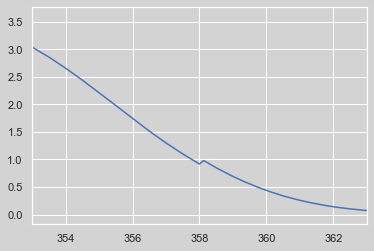

NameError: name 'plot_dir' is not defined

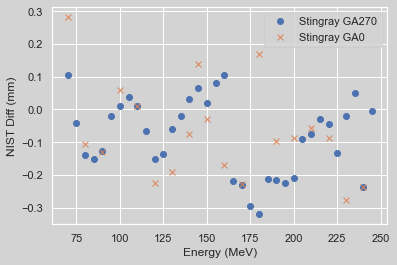

In [8]:
###### IDD offset correction, stitching and cropping:
# for stingray GA270, add the same 1.2 mm offset to all IDDs
#load pickle files and concatenate
pickle_file = os.path.join(pickle_dir,'20211102_SR_070_160_G270','data.p')
with open(pickle_file, 'rb') as f:
    sr_g270_1 = pickle.load(f)

pickle_file = os.path.join(pickle_dir,'20211101_SR_165_245_G270','data.p')
with open(pickle_file, 'rb') as f:
    sr_g270_2 = pickle.load(f)

sr_g270_offset = {**sr_g270_1, **sr_g270_2}

# apply offset
sr_pp_270 = {}
energies = np.arange(70.0,250.0,5.).tolist()
for en in energies:
    try:
        sr270 = sr_g270_offset[en].data[0,:]
    except:
        pass

    for i in range(len(sr270)):
        sr_g270_offset[en].data[0,i] = sr270[i] - sr_med_offset # additional -0.3 mm fudge

    sr_pp_270[en] = PeakProperties(sr_g270_offset[en].data,en)

# fill GA0 Stingray 240 MeV distal tail with GA270 data
#load pickle files and concatenate
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data.p')
with open(pickle_file, 'rb') as f:
    sr_g0_1 = pickle.load(f)

pickle_file = os.path.join(pickle_dir,'20211117_SR_145_190_G0','data.p')
with open(pickle_file, 'rb') as f:
    sr_g0_2 = pickle.load(f)

sr_g0 = {**sr_g0_1, **sr_g0_2}

#max depth of GA0
en = 240.
ga0_maxdepth = np.max(sr_g0[en].data[0,...])
ga270_tail = sr_g270_offset[en].data[0:2,...]
ga270_tail_idx = [i for i,v in enumerate(ga270_tail[0,...]) if v > ga0_maxdepth]
ga270_stitch = np.hstack((sr_g0[en].data[0:2,:],ga270_tail[:,ga270_tail_idx]))
plt.plot(ga270_stitch[0,...],ga270_stitch[1,...]) # if stitching is successful, there should be no discontinuity in the plot
plt.xlim([ga0_maxdepth-5,ga0_maxdepth+5])
plt.show()
sr_g270_offset[en].data = ga270_stitch

# remove IDD distal tails where Dose = 0.0025
for en in energies:
    d = sr_g270_offset[en].data[0:2,:]
    d = d[:,d[1,:] > 2.5e-3]
    sr_g270_offset[en].data = d

# recalculate all metrics
sr_pp_270 = {}
sr270_nist = []
sr_recorded_energies270 = []
pk270 = []
srd80_270 = []
for en in energies:
    try:
        sr270 = sr_g270_offset[en]
        sr_pp_270[en] = PeakProperties(sr270.data,en)
        sr270_nist.append(sr_pp_270[en].NISTDiff)
        sr_recorded_energies270.append(en)
        srd80_270.append(sr_pp_270[en].Dist80)
        a = sr_pp_270[en]
        pk270.append(a.Prox90+(a.Dist90-a.Prox90)*0.5 )
    except:
        pass

plt.plot(sr_recorded_energies270,sr270_nist,'o')
plt.plot(sr_recorded_energies,sr0_nist,'x')
plt.xlabel('Energy (MeV)')
plt.ylabel('NIST Diff (mm)')
plt.legend(['Stingray GA270','Stingray GA0'])
#plt.show()
fig = plt.gcf()
#fig.savefig(os.path.join(plot_dir,'NIST_Diff_Stingray_corrected.png'),dpi=600)

# pickle the processed data
save_dir = pickle_dir
with open(os.path.join(save_dir,'Stingray_GA270_offset_data.p'), 'wb') as d:
    pickle.dump(sr_g270_offset, d, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(save_dir,'Stingray_GA270_offset_data_properties.p'), 'wb') as dp:
    pickle.dump(sr_pp_270, dp, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'plot_dir' is not defined

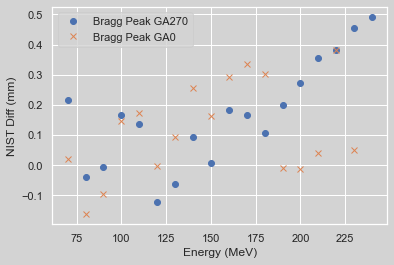

In [9]:
###### IDD offset correction:
# for Bragg Peak GA270, add the same -0.4 mm offset to all IDDs
#load pickle files and concatenate
pickle_file = os.path.join(pickle_dir,'20211125_BP_070_230_G0','data.p')
with open(pickle_file, 'rb') as f:
    bp_g270_1 = pickle.load(f)

pickle_file = os.path.join(pickle_dir,'20211124_BP_070_240_G270','data.p')
with open(pickle_file, 'rb') as f:
    bp_g270_2 = pickle.load(f)

bp_g270_offset = {**bp_g270_1, **bp_g270_2}

# apply offset and recalculate all metrics
bp_pp_270 = {}
bp270_nist = []
bp_recorded_energies270 = []
bp_pk270 = []
bpd80_270 = []
energies = np.arange(70.0,250.0,5.).tolist()
for en in energies:
    try:
        bp270 = bp_g270_offset[en].data[0,:]
        for i in range(len(bp270)):
            bp_g270_offset[en].data[0,i] = bp270[i] - bp_med_offset # additional -0.3 mm fudge

        bp_pp_270[en] = PeakProperties(bp_g270_offset[en].data,en)
        bp270_nist.append(bp_pp_270[en].NISTDiff)
        bp_recorded_energies270.append(en)
        bpd80_270.append(bp_pp_270[en].Dist80)
        b = sr_pp_270[en]
        bp_pk270.append(b.Prox90+(b.Dist90-b.Prox90)*0.5 )
    except:
        pass


plt.plot(bp_recorded_energies270,bp270_nist,'o')
plt.plot(bp_recorded_energies,bp0_nist,'x')
plt.xlabel('Energy (MeV)')
plt.ylabel('NIST Diff (mm)')
plt.legend(['Bragg Peak GA270','Bragg Peak GA0'])
#plt.show()
fig = plt.gcf()
#fig.savefig(os.path.join(plot_dir,'NIST_Diff_BraggPeak_corrected.png'),dpi=600)

# pickle the processed data
save_dir = pickle_dir
with open(os.path.join(save_dir,'BraggPeak_GA270_offset_data.p'), 'wb') as d:
    pickle.dump(bp_g270_offset, d, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(save_dir,'BraggPeak_GA270_offset_data_properties.p'), 'wb') as dp:
    pickle.dump(bp_pp_270, dp, protocol=pickle.HIGHEST_PROTOCOL)

D80 Differences between GA 270 & GA0 for stingray at each energy: 


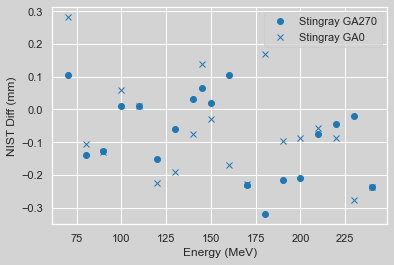

Stingray GA270-GA0 mean (StDev) D80 offset = -0.01 (0.160) mm
Stingray GA0 mean (StDev) NIST Difference = -0.07 (0.145) mm
Stingray GA270 mean (StDev) NIST Difference = -0.08 (0.122) mm
D80 Differences between GA 270 & GA0 for bragg peak at each energy: 


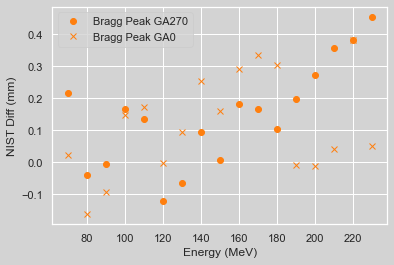

Bragg peak GA270-GA0 mean (StDev) D80 offset = 0.03 (0.188) mm
Bragg peak GA0 mean (StDev) NIST Difference = 0.12 (0.153) mm
Bragg peak GA270 mean (StDev) NIST Difference = 0.15 (0.157) mm


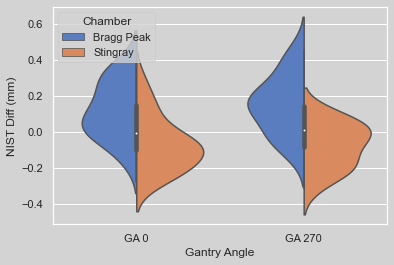

In [21]:
##### Plot NIST Diffs for Bragg Peak and Stingray Chambers
# stingray at GA0
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0_1 = pickle.load(f)

pickle_file = os.path.join(pickle_dir,'20211117_SR_145_190_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g0 = {**sr_g0_1, **sr_g0_2}

# corrected bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'Stingray_GA270_offset_data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g270 = pickle.load(f)

# bragg peak at GA0
pickle_file = os.path.join(pickle_dir,'20211125_BP_070_230_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    bp_g0 = pickle.load(f)

# corrected bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'BraggPeak_GA270_offset_data_properties.p')
with open(pickle_file, 'rb') as f:
    bp_g270 = pickle.load(f)


plot_dir = 'O:\protons\Work in Progress\AlexG\pdd-analysis\plots'  
# sr_avg_offset, sr_med_offset, sr_sd_offset, sr_avg_nist270, sr_avg_nist0, sr_med_nist0, sr_std_nist270, sr_std_nist0, sr0_nist, sr270_nist, sr_recorded_energies = sr_analyse(sr_g0, sr_g270, plot=os.path.join(plot_dir,'Stingray_NISTDiff_corrected.png'))
# bp_avg_offset, bp_med_offset, bp_sd_offset, bp_avg_nist270, bp_avg_nist0, bp_med_nist0, bp_std_nist270, bp_std_nist0, bp0_nist, bp270_nist, bp_recorded_energies = bp_analyse(bp_g0, bp_g270, plot=os.path.join(plot_dir,'BraggPeak_NISTDiff_corrected.png'))
# violin_diffs(sr0_nist, sr270_nist, bp0_nist, bp270_nist, plot=os.path.join(plot_dir,'nist_diff_violin_corrected.png'))
sr_avg_offset, sr_med_offset, sr_sd_offset, sr_avg_nist270, sr_avg_nist0, sr_med_nist0, sr_std_nist270, sr_std_nist0, sr0_nist, sr270_nist, sr_recorded_energies = sr_analyse(sr_g0, sr_g270)
bp_avg_offset, bp_med_offset, bp_sd_offset, bp_avg_nist270, bp_avg_nist0, bp_med_nist0, bp_std_nist270, bp_std_nist0, bp0_nist, bp270_nist, bp_recorded_energies = bp_analyse(bp_g0, bp_g270)
violin_diffs(sr0_nist, sr270_nist, bp0_nist, bp270_nist)

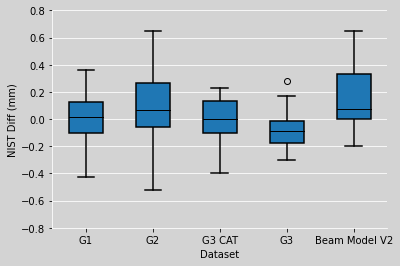

In [127]:
#### Compare NIST Diffs across gantries

import pandas as pd
import seaborn as sns
plot_dir = 'O:\protons\Work in Progress\AlexG\pdd-analysis\plots'  
excel_file = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar\\G3_intercomparison.xlsx'
df = pd.read_excel(excel_file, sheet_name="D80", usecols='H:L')
ax = df.boxplot(patch_artist=True,color=dict(boxes='tab:blue', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5, color='k'),
             flierprops=dict(linestyle='-', linewidth=1.5, color='tab:purple'),
             medianprops=dict(linestyle='-', linewidth=1., color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5, color='k'),
             showfliers=True, grid=False, rot=0)
ax.set_facecolor('lightgrey')
ax.set_xticklabels(['G1','G2','G3 CAT','G3','Beam Model V2'])
ax.set_xlabel('Dataset')
ax.set_ylabel('NIST Diff (mm)')
ax.grid(color='w', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.set_ylim([-0.8, 0.8])
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'Boxplots_corrected.png'),dpi=600)


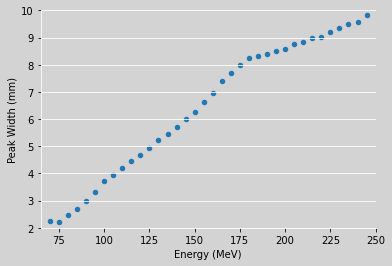

In [110]:
import pickle
import pandas as pd
import numpy as np
#### visualise and record analysis for PTP ratio and Peak Width
plot_dir = 'O:\protons\Work in Progress\AlexG\pdd-analysis\plots'  
excel_file = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar\\G3_intercomparison.xlsx'# load pickle data
pickle_dir = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar'

# stingray at GA0
pickle_file = os.path.join(pickle_dir,'20211118_SR_070_240_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0_1 = pickle.load(f)

pickle_file = os.path.join(pickle_dir,'20211117_SR_145_190_G0','data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g0_2 = pickle.load(f)

# concatenate stingray GA270 datasets
sr_g0 = {**sr_g0_1, **sr_g0_2}

# corrected bragg peak at GA270
pickle_file = os.path.join(pickle_dir,'Stingray_GA270_offset_data_properties.p')
with open(pickle_file, 'rb') as f:
    sr_g270 = pickle.load(f)

# interleave Stingray data from both angles
energies = np.arange(70.0,250.0,5.).tolist()
sr_metrics = pd.DataFrame(columns=['Energy','Prox90','Dist90','Dist80','NistDiff','PTPR','PeakWidth'])
for en in energies:
    try:
        a = sr_g0[en]
    except:
        a = sr_g270[en]
    
    m = pd.Series([en,
            float(a.Prox90),
            float(a.Dist90),
            float(a.Dist80),
            float(a.NISTDiff),
            float(a.PTPR),
            float(a.PeakWidth)],
            index=sr_metrics.columns)
    sr_metrics = sr_metrics.append(m, ignore_index=True)

ax = sr_metrics.plot.scatter("Energy","PeakWidth",c='tab:blue')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Peak Width (mm)')
ax.set_xlim([65, 250])
ax.set_ylim([2, 10])
ax.grid(color='w', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'PeakWidth_corrected.png'),dpi=600)
sr_metrics.to_excel(os.path.join(pickle_dir,'StingrayGA0Corrected.xlsx'))


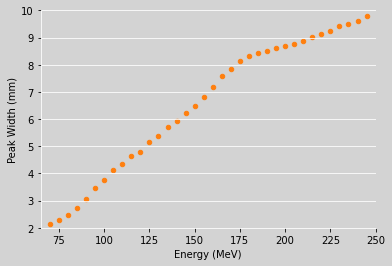

In [167]:
# collect beam model data to pandas & excel
bm_asc = 'TPS_IDD_70-245-MeV_v2.0.asc'
bm_data = DepthDoseFile(bm_asc)
bm_metrics = pd.DataFrame(columns=['Energy','Prox90','Dist90','Dist80','NistDiff','PTPR','PeakWidth'])
energies = np.arange(70.0,250.0,5.).tolist()
for en in energies:
    try:
        idx = bm_data.energy.index(en)
    except:
        pass

    bm_pp = PeakProperties(data=bm_data.data[idx], energy=en, plateau_depth=25, bortfeld_fit_bool=False)
    m = pd.Series([en,
            float(bm_pp.Prox90),
            float(bm_pp.Dist90),
            float(bm_pp.Dist80),
            float(bm_pp.NISTDiff),
            float(bm_pp.PTPR),
            float(bm_pp.PeakWidth)],
            index=sr_metrics.columns)
    bm_metrics = bm_metrics.append(m, ignore_index=True)

ax = bm_metrics.plot.scatter("Energy","PeakWidth",c='tab:orange')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Peak Width (mm)')
ax.set_xlim([65, 250])
ax.set_ylim([2, 10])
ax.grid(color='w', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'PeakWidth_beammodel.png'),dpi=600)
bm_metrics.to_excel(os.path.join(pickle_dir,'BeamModel_V2_Metrics.xlsx'))


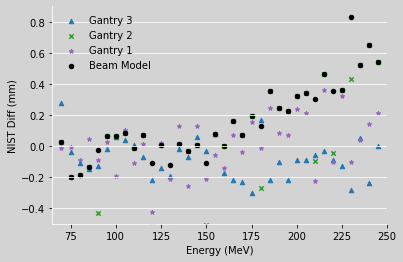

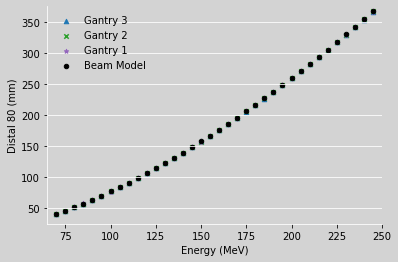

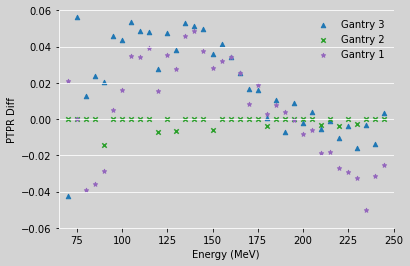

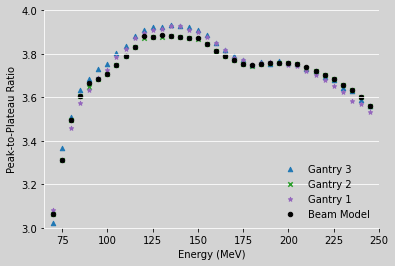

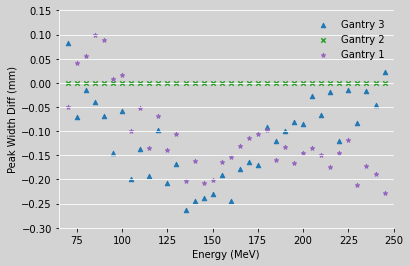

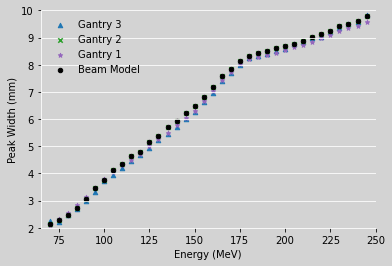

In [180]:
### plot comparisons of D80 Diff, PTP Ratio, Peak Width vs. Energy
excel_file = 'C:\\Users\\agrimwoo\\NHS\\(Canc) Radiotherapy - PBT Physics Team - PBT Physics Team\\QAandCommissioning\\Gantry 3\\Commissioning\\IDD\\pickle_jar\\G3_intercomparison.xlsx'# load pickle data
proc_d80 = pd.read_excel(excel_file,"D80")
proc_ptpr = pd.read_excel(excel_file,"PTPR")
proc_pw = pd.read_excel(excel_file,"PeakWidth")

# NIST DIFF (D80 Diff)
ax = proc_d80.plot.scatter(x="Energy",y="D80_G3_StingrayDiff", marker="^", color="tab:blue")
proc_d80.plot.scatter(x="Energy",y="D80_G2Diff", ax=ax, marker='x', color="tab:green")
proc_d80.plot.scatter(x="Energy",y="D80_G1Diff", ax=ax, marker='*', color="tab:purple")
proc_d80.plot.scatter(x="Energy",y="D80_BMDiff", ax=ax, marker='o', color="k")
ax.set_xlim([65, 250])
ax.set_ylim([-0.5, 0.9])
ax.grid(color='w', axis='y')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('NIST Diff (mm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.legend(["Gantry 3", "Gantry 2", "Gantry 1", "Beam Model"], framealpha=0)
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'NISTDiff_vs_E.png'),dpi=600)

# Distal 80
ax = proc_d80.plot.scatter(x="Energy",y="D80_G3_Stingray", marker="^", color="tab:blue")
proc_d80.plot.scatter(x="Energy",y="D80_G2", ax=ax, marker='x', color="tab:green")
proc_d80.plot.scatter(x="Energy",y="D80_G1", ax=ax, marker='*', color="tab:purple")
proc_d80.plot.scatter(x="Energy",y="D80_BM", ax=ax, marker='o', color="k")
ax.set_xlim([65, 250])
ax.set_ylim([25, 375])
ax.grid(color='w', axis='y')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Distal 80 (mm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.legend(["Gantry 3", "Gantry 2", "Gantry 1", "Beam Model"], framealpha=0)
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'Diff80_vs_E.png'),dpi=600)

# PTPR Diff from Beam Model
ax = proc_ptpr.plot.scatter(x="Energy",y="PTPR_G3Diff", marker="^", color="tab:blue")
proc_ptpr.plot.scatter(x="Energy",y="PTPR_G2Diff", ax=ax, marker='x', color="tab:green")
proc_ptpr.plot.scatter(x="Energy",y="PTPR_G1Diff", ax=ax, marker='*', color="tab:purple")
ax.set_xlim([65, 250])
ax.set_ylim([-0.06, 0.06])
ax.grid(color='w', axis='y')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('PTPR Diff')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.legend(["Gantry 3", "Gantry 2", "Gantry 1"], framealpha=0)
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'PTPRDiff_vs_E.png'),dpi=600)

# PTPR
ax = proc_ptpr.plot.scatter(x="Energy",y="PTPR_G3", marker="^", color="tab:blue")
proc_ptpr.plot.scatter(x="Energy",y="PTPR_G2", ax=ax, marker='x', color="tab:green")
proc_ptpr.plot.scatter(x="Energy",y="PTPR_G1", ax=ax, marker='*', color="tab:purple")
proc_ptpr.plot.scatter(x="Energy",y="PTPR_BM", ax=ax, marker='o', color="k")
ax.set_xlim([65, 250])
ax.set_ylim([3., 4.])
ax.grid(color='w', axis='y')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Peak-to-Plateau Ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.legend(["Gantry 3", "Gantry 2", "Gantry 1", "Beam Model"], framealpha=0)
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'PTPR_vs_E.png'),dpi=600)

# PeakWidth Diff
ax = proc_pw.plot.scatter(x="Energy",y="PW_G3Diff", marker="^", color="tab:blue")
proc_pw.plot.scatter(x="Energy",y="PW_G2Diff", ax=ax, marker='x', color="tab:green")
proc_pw.plot.scatter(x="Energy",y="PW_G1Diff", ax=ax, marker='*', color="tab:purple")
ax.set_xlim([65, 250])
ax.set_ylim([-.3, .15])
ax.grid(color='w', axis='y')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Peak Width Diff (mm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.legend(["Gantry 3", "Gantry 2", "Gantry 1"], framealpha=0)
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'PeakWidthDiff_vs_E.png'),dpi=600)

# PeakWidth
ax = proc_pw.plot.scatter(x="Energy",y="PW_G3", marker="^", color="tab:blue")
proc_pw.plot.scatter(x="Energy",y="PW_G2", ax=ax, marker='x', color="tab:green")
proc_pw.plot.scatter(x="Energy",y="PW_G1", ax=ax, marker='*', color="tab:purple")
proc_pw.plot.scatter(x="Energy",y="PW_BM", ax=ax, marker='o', color="k")
ax.set_xlim([65, 250])
ax.set_ylim([2., 10.])
ax.grid(color='w', axis='y')
ax.set_facecolor('lightgrey')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Peak Width (mm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.legend(["Gantry 3", "Gantry 2", "Gantry 1", "Beam Model"], framealpha=0)
fig = ax.get_figure()
fig.set_facecolor('lightgray')
#fig.savefig(os.path.join(plot_dir,'PeakWidth_vs_E.png'),dpi=600)

